In [2]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import LogFormatterSciNotation
from matplotlib.ticker import PercentFormatter
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import os
import sys
from datetime import timedelta, date
import csv
mpl.rcParams['figure.dpi'] = 300
import matplotlib.ticker as ticker
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter

In [3]:
mpl.rcParams['figure.dpi'] = 175

In [4]:
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))

In [5]:
#https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings-in-python/49955617#49955617
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()

In [6]:
conn = sqlite3.connect("../agg-data/agg_fcc.db")

In [7]:
df_load = pd.read_sql_query("select * from agg_dlping;", conn)
df = pd.read_sql_query("select * from agg_udplatency;", conn)

In [8]:
conn.close()

In [9]:
df_load = df_load[df_load['med_rtt_avg'] > 0.]
df = df[df['med_rtt_avg'] > 0.]

df_load = df_load[df_load['sum_suc'] > 0.]
df = df[df['sum_suc'] > 0.]

In [10]:
df['dtime'] = pd.to_datetime(df['dtime'])
df['year'] = df['dtime'].dt.strftime('%Y')


df_load['dtime'] = pd.to_datetime(df_load['dtime'])
df_load['year'] = df_load['dtime'].dt.strftime('%Y')


In [11]:
df['med_rtt_avg'] = df['med_rtt_avg']/1000
df_load['med_rtt_avg'] = df_load['med_rtt_avg']/1000

In [12]:
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [13]:
conn_tech = sqlite3.connect("../agg-data/unit-profile.db")
df_tech = pd.read_sql_query('select * from "unit-profile"', conn_tech)



#fix AT&T IPBB
df_tech['technology'] = np.where(df_tech.isp == 'AT&T IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'UVERSE', 'DSL', df_tech.technology)

def isp_names(df, column):
    df[column] = np.where(df[column].str.startswith("Verizon"), 'Verizon', df[column])
    df[column] = np.where(df[column] == "TimeWarner", 'Time Warner Cable', df[column])
    df[column] = np.where(df[column].str.startswith("Frontier"), 'Frontier', df[column])
    df[column] = np.where(df[column] == "Qwest", 'CenturyLink', df[column])
    df[column] = np.where(df[column].str.startswith("Cincinnati Bell"), 'Cincinnati Bell', df[column])
    df[column] = np.where(df[column].str.startswith("AT&T"), 'AT&T', df[column])
    df[column] = np.where(df[column] == "TWC", 'Time Warner Cable', df[column])
    
isp_names(df_tech, 'isp')

df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]
df_satellite_isps = df_satellite_isps[~df_satellite_isps.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
usable_sat_units = df_satellite_isps.unit_id.unique().tolist()
usable_sat_units.remove(1273)
usable_sat_units.remove(801252)
usable_sat_units.remove(13236)
usable_sat_units.remove(999051)
usable_sat_units.remove(216686)


df_att = df_tech[(df_tech.year == '2018') & (df_tech.isp.isin(['AT&T']))]
df_att = df_att[~df_att.unit_id.isin(df_tech[df_tech.year == '2019'].unit_id.unique())]
att_probes_carry_fwd = df_att.unit_id.unique().tolist()
att_probes_carry_fwd.remove(507)
att_probes_carry_fwd.remove(5655)
att_probes_carry_fwd.remove(7460)
att_probes_carry_fwd.remove(27738)
att_probes_carry_fwd.remove(216054)
att_probes_carry_fwd.remove(216146)
att_probes_carry_fwd.remove(805166)
att_probes_carry_fwd.remove(805490)
att_probes_carry_fwd.remove(805630)
att_probes_carry_fwd.remove(805782)
att_probes_carry_fwd.remove(811954)
att_probes_carry_fwd.remove(941780)
att_probes_carry_fwd.remove(994195)
att_probes_carry_fwd.remove(994419)
att_probes_carry_fwd.remove(999719)

#Hawaiian Telcom -- remove, bought by cincinnati bell
df_hitel = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hawaiian Telcom']))]
df_hitel = df_hitel[~df_hitel.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
hit_probes_carry_fwd = df_hitel.unit_id.unique().tolist()
hit_probes_carry_fwd.remove(995125)
hit_probes_carry_fwd.remove(995121)
hit_probes_carry_fwd = []


df_tech_for_merge = pd.DataFrame()
for year in ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    if year == '2012':
        df_tmp = df_tech[df_tech.year == '2012']
        df_tmp_for_append = df_tmp[df_tmp.month == '09']
        list_2012_newer_units = df_tmp_for_append.unit_id.to_list()
        list_2012_older_units = df_tmp[df_tmp.month == '04'].unit_id.to_list()
        for unit_id in list_2012_older_units:
            if not unit_id in list_2012_newer_units:
                df_tmp_for_append = pd.concat([df_tmp_for_append, df_tmp[(df_tmp.month == '04') & (df_tmp.unit_id == unit_id)]], ignore_index=True)
    elif year == '2013':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2014':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2015':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2016':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2017':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2018':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2018'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
    elif year == '2019':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd + att_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2019'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
        
    df_tech_for_merge = pd.concat([df_tech_for_merge, df_tmp_for_append], ignore_index=True)

/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
for year in years:
        #UDP Latency
        df_tmp = df[(df.year == year) & (df['med_rtt_avg'] < 2147483.)]["med_rtt_avg"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            print(year)
            print('')
            #print(make_cdf(df_tmp)[0])
            print('')
            print(df_tmp.describe(percentiles=[.33, .95, .99, .75], include='all'))
            print('')
            print('')

2012


count    3.100746e+06
mean     3.551489e+01
std      8.275521e+01
min      5.010000e-01
33%      1.797700e+01
50%      2.431100e+01
75%      3.520800e+01
95%      6.565250e+01
99%      2.469528e+02
max      2.707618e+03
Name: med_rtt_avg, dtype: float64


2013


count    4.024739e+06
mean     4.148373e+01
std      9.225100e+01
min      2.410000e-01
33%      1.983650e+01
50%      2.682450e+01
75%      3.925900e+01
95%      7.058800e+01
99%      6.504390e+02
max      2.939812e+03
Name: med_rtt_avg, dtype: float64


2014


count    5.731421e+06
mean     4.070518e+01
std      9.391274e+01
min      5.455000e-01
33%      1.851400e+01
50%      2.459450e+01
75%      3.581500e+01
95%      6.930900e+01
99%      6.482166e+02
max      2.730179e+03
Name: med_rtt_avg, dtype: float64


2015


count    5.842430e+06
mean     4.183214e+01
std      1.006357e+02
min      2.810000e-01
33%      1.753900e+01
50%      2.332800e+01
75%      3.334400e+01
95%      7.250700e+01
99%      6.522630e+02
max   

In [15]:
for year in years:
        #UDP Latency under load
        df_tmp = df_load[(df_load.year == year) & (df_load.med_rtt_avg < 74838.)]["med_rtt_avg"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            print(year)
            print('')
            #print(make_cdf(df_tmp)[0])
            print('')
            print(df_tmp.describe(percentiles=[.33, .95, .99, .75], include='all'))
            print('')
            print('')

2012


count    3.067291e+06
mean     2.443822e+02
std      3.273027e+02
min      2.457000e+00
33%      5.892300e+01
50%      1.075705e+02
75%      2.952738e+02
95%      8.951578e+02
99%      1.580167e+03
max      2.733324e+03
Name: med_rtt_avg, dtype: float64


2013


count    3.955453e+06
mean     2.430204e+02
std      3.282745e+02
min      8.190000e-01
33%      5.622250e+01
50%      1.072710e+02
75%      3.179090e+02
95%      9.699136e+02
99%      1.593528e+03
max      2.766164e+03
Name: med_rtt_avg, dtype: float64


2014


count    5.632023e+06
mean     2.362096e+02
std      3.297217e+02
min      2.066000e+00
33%      5.470050e+01
50%      1.008890e+02
75%      3.036295e+02
95%      9.817785e+02
99%      1.606715e+03
max      2.914077e+03
Name: med_rtt_avg, dtype: float64


2015


count    5.708687e+06
mean     2.322727e+02
std      3.292791e+02
min      8.820000e-01
33%      5.313100e+01
50%      9.686750e+01
75%      2.837585e+02
95%      9.811094e+02
99%      1.569080e+03
max   

In [ ]:
def better_general_format(num):
    if num >= 2**7:
        return r'$2^{%s}$' % format(np.log(num)/np.log(2), 'g')
    elif num <= -(2**7):
        num = -num
        return r'-$2^{%s}$' % format(np.log(num)/np.log(2), 'g')
    num = format(num, 'g')
    return num

In [17]:
df_load_new = df_load[df_load.year == '2019'].merge(df_tech_for_merge[df_tech_for_merge.year == '2019'], on = 'unit_id')

df_new = df[df.year == '2019'].merge(df_tech_for_merge[df_tech_for_merge.year == '2019'], on = 'unit_id')



In [36]:
unit_ids_that_likely_changed_tech_from_satellite = [801252, 942262, 999051]
df_new[df_new.unit_id.isin(unit_ids_that_likely_changed_tech_from_satellite)].groupby('unit_id', as_index=False).agg({'med_rtt_avg':'min'})

,unit_id,med_rtt_avg
0,801252,15.7725
1,942262,23.1090
2,999051,17.0655


In [18]:
techs = ['DSL', 'FIBER', 'CABLE', 'IPBB', 'SATELLITE']
colors = {'DSL':'C0', 'FIBER':'C1', 'CABLE':'C2', 'IPBB':'C3', 'SATELLITE':'C4'}

In [19]:
for tech in techs:
        #UDP Latency
        df_tmp = df_new[(df_new.technology == tech) & (df_new['med_rtt_avg'] < 2147483.)]["med_rtt_avg"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            print(tech)
            print('')
            #print(make_cdf(df_tmp)[0])
            print('')
            print(df_tmp.describe(percentiles=[.33, .95, .99, .75], include='all'))
            print('')
            print('')

DSL


count    1.249264e+06
mean     4.235979e+01
std      5.399053e+01
min      1.849500e+00
33%      2.585400e+01
50%      3.187550e+01
75%      4.800950e+01
95%      8.670300e+01
99%      2.072686e+02
max      2.696099e+03
Name: med_rtt_avg, dtype: float64


FIBER


count    593278.000000
mean         14.767147
std          14.156490
min           1.323500
33%           9.667000
50%          11.476000
75%          17.882000
95%          36.096500
99%          42.175690
max         977.407000
Name: med_rtt_avg, dtype: float64


CABLE


count    1.014434e+06
mean     2.517665e+01
std      4.824348e+01
min      1.101500e+00
33%      1.471500e+01
50%      1.844100e+01
75%      2.689500e+01
95%      4.625900e+01
99%      9.702806e+01
max      1.752890e+03
Name: med_rtt_avg, dtype: float64


SATELLITE


count    108815.000000
mean        683.687832
std          71.142927
min          57.512000
33%         639.847620
50%         663.613000
75%         725.301000
95%         813.930650
99% 

In [20]:
for tech in techs:
        #UDP Latency under load
        df_tmp = df_load_new[(df_load_new.technology == tech) & (df_load_new.med_rtt_avg < 74838.)]["med_rtt_avg"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            print(tech)
            print('')
            #print(make_cdf(df_tmp)[0])
            print('')
            print(df_tmp.describe(percentiles=[.33, .95, .99, .75], include='all'))
            print('')
            print('')

DSL


count    1.111426e+06
mean     1.997838e+02
std      2.770113e+02
min      2.137500e+00
33%      6.043000e+01
50%      8.527150e+01
75%      2.191107e+02
95%      7.668718e+02
99%      1.425418e+03
max      2.987195e+03
Name: med_rtt_avg, dtype: float64


FIBER


count    550612.000000
mean         68.277816
std          73.058128
min           1.271000
33%          30.497500
50%          65.536000
75%          81.671250
95%         155.355700
99%         393.935070
max        2038.488000
Name: med_rtt_avg, dtype: float64


CABLE


count    923900.000000
mean        132.936894
std         159.101201
min           1.871500
33%          35.693000
50%          59.679750
75%         192.220625
95%         401.168275
99%         703.372100
max        2332.083500
Name: med_rtt_avg, dtype: float64


SATELLITE


count    65619.000000
mean       766.445094
std        204.255715
min         38.401500
33%        654.179880
50%        703.174000
75%        820.604500
95%       1122.988000
99

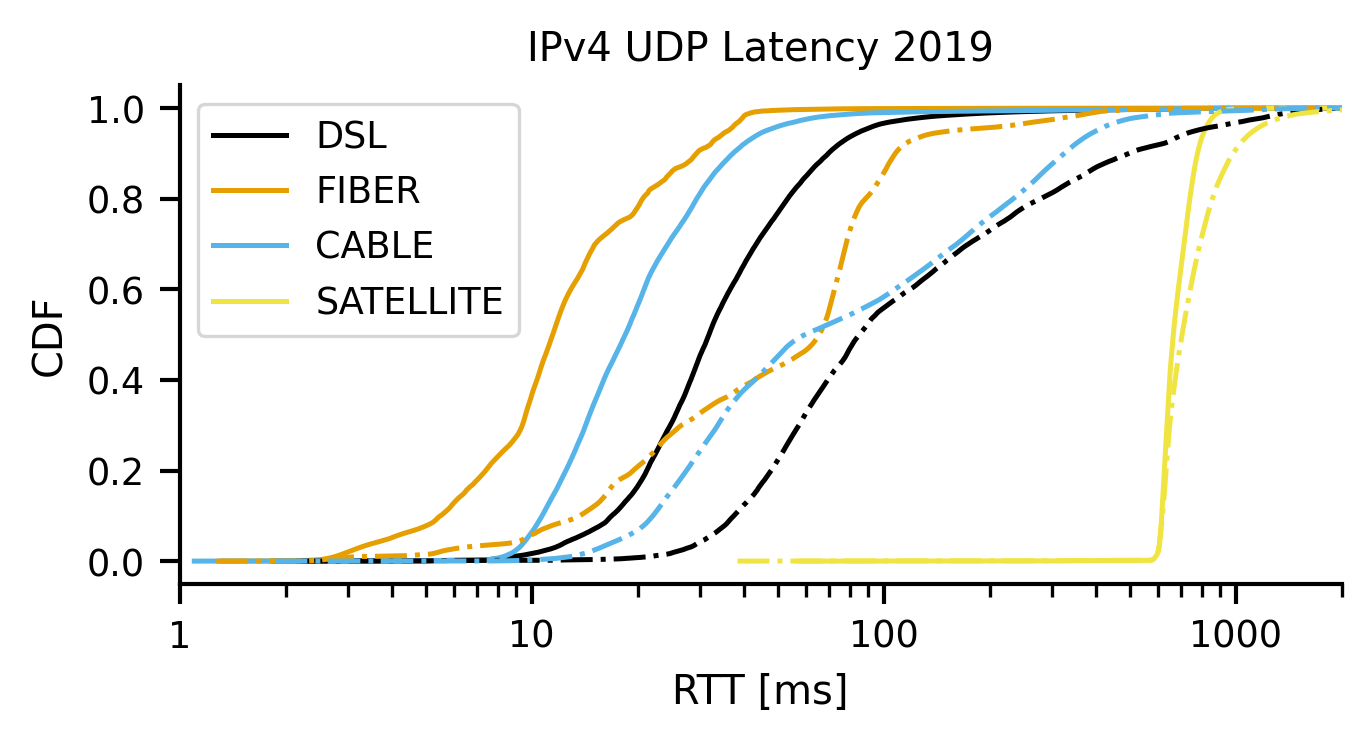

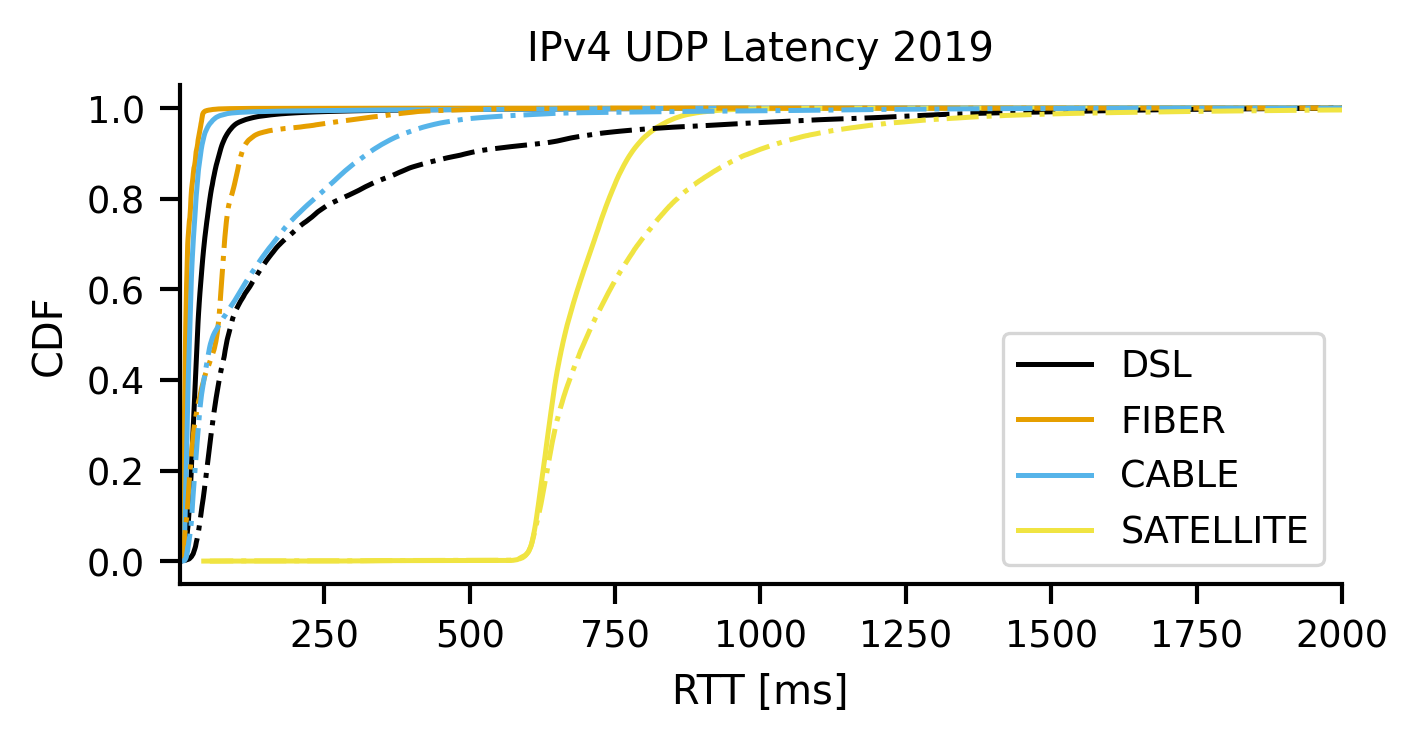

In [147]:
for log in [True, False]:

    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))


    lnwidth = 1.2
    mrksize = 0

    for tech in techs:
        #UDP Latency
        df_tmp = df_new[(df_new.technology == tech) & (df_new['med_rtt_avg'] < 2147483.)]["med_rtt_avg"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            dfplt.plot(y="med_rtt_avg", ax=ax, label=tech, marker='.', logx=log, markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[tech])
    for tech in techs:
        #UDP Latency under Load
        df_tmp = df_load_new[(df_load_new.technology == tech) & (df_load_new.med_rtt_avg < 74838.)]["med_rtt_avg"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            dfplt.plot(y="med_rtt_avg", ax=ax, label='_'+tech, marker='.', logx=log, markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[tech], linestyle='-.')

    if log:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))

    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='upper left', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    
    ax.set_xlim(left=1, right=2000)
    


    ax.set_title("IPv4 UDP Latency 2019")

    
    ax.set_xlabel("RTT [ms]")

    
    ax.set_ylabel("CDF")


    if log:
        fig.savefig('UDP_Latency/Latencies-CDF-by-ACCESSTECH-IPv4-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('UDP_Latency/Latencies-CDF-by-ACCESSTECH-IPv4.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [24]:
#from HTTP-GET-MT-CDF:
usable_sat_units = [605,
 1273,
 12893,
 13236,
 32384,
 32385,
 32403,
 32419,
 32548,
 216686,
 589792,
 605674,
 614078,
 614120,
 614134,
 614184,
 614196,
 614220,
 615144,
 615152,
 615366,
 620744,
 620750,
 623976,
 623992,
 797804,
 799496,
 801248,
 806268,
 915802,
 939188,
 939190,
 940672,
 941604,
 941610,
 941612,
 941776,
 941934,
 941972,
 941988,
 942528,
 942536,
 942596,
 942632,
 942654,
 943274,
 943290,
 945144,
 948134,
 948956,
 949030,
 949082,
 949084,
 949158,
 997489,
 997989,
 997993,
 998005,
 998015,
 998019,
 998025,
 998035,
 998039,
 998045,
 998053,
 998339,
 998343,
 998345,
 998373,
 998783,
 998807,
 998997,
 999003,
 999005,
 999017,
 999019,
 1006420,
 1006964,
 1009114,
 1009360,
 1009388,
 1009534,
 1009996]

In [97]:
df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]
satellite_unit_ids = df_satellite_isps.unit_id.unique().tolist()
for swapped_to_non_sat in df_tech[(df_tech.year == '2019') & (df_tech.unit_id.isin(satellite_unit_ids))].unit_id.unique():
    satellite_unit_ids.remove(swapped_to_non_sat)
usable_sat_units = satellite_unit_ids

In [106]:
df_load_sat_latency_check = df_load[(df_load.year == '2019') & (df_load.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')

df_sat_latency_check = df[(df.year == '2019') & (df.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')



In [109]:
df_load_sat_latency_check = df_load[(df_load.year == '2018') & (df_load.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')

df_sat_latency_check = df[(df.year == '2018') & (df.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')



In [ ]:
for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14

    if log:
        ax.set_xscale('log', basex=2)

    
    lnwidth = 0.2
    mrksize = 1

    dfplt = make_cdf(df_sat_latency_check['med_rtt_avg'])
    dfplt.plot(y="delta", ax=ax, label='IPv4', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    
    dfplt = make_cdf(df_sat_latency_check.groupby(['unit_id', 'year'], as_index=False).agg({'med_rtt_avg':'median'})['med_rtt_avg'])
    dfplt.plot(y="delta", ax=ax, label='IPv4 Yearly Median per probe', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    



        
    if log:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))


    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='upper left', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("Satellite Latencies")
    ax.set_xlabel("UDP Latency [ms]")
    ax.set_ylabel("CDF")
    plt.show()

In [43]:
df_sat_latency_check[df_sat_latency_check.med_rtt_avg < 500].unit_id.value_counts().head(10).index.tolist()

[1273, 216686, 13236, 620744, 1009534, 948134, 915802, 949082, 32419, 999005]

In [101]:
df_sat_latency_check[df_sat_latency_check.med_rtt_avg < 500].unit_id.value_counts().head(10).index.tolist()

[801252, 1273, 999051, 216686, 13236, 620744, 1009534, 948134, 915802, 949082]

In [46]:
df_sat_latency_check

,unit_id,dtime,target,location_id,med_rtt_avg,med_rtt_min,med_rtt_max,med_rtt_std,sum_suc,sum_fail,year
34622518,605,2019-01-01,ispmon.samknows.mlab1v4.atl01.measurement-lab.org,9014078,609.2560,573279.5,685626.5,15741.0,26654,9,2019
34622519,605,2019-01-01,ispmon.samknows.mlab1v4.atl05.measurement-lab.org,9014078,628.3630,587277.5,698578.5,19222.0,7868,1,2019
34622520,605,2019-01-01,ispmon.samknows.mlab1v4.nuq07.measurement-lab.org,9014078,578.2915,552226.0,708581.0,14822.0,2319,1,2019
34622521,605,2019-01-02,ispmon.samknows.mlab1v4.atl01.measurement-lab.org,9014078,614.6200,580198.0,736597.0,16974.0,27338,22,2019
34622522,605,2019-01-02,ispmon.samknows.mlab1v4.atl04.measurement-lab.org,9014078,621.3190,584920.0,679256.0,15586.0,15549,205,2019
...,...,...,...,...,...,...,...,...,...,...,...
41175546,1009996,2019-12-27,samknows1.chi2.level3.net,49382921,752.2230,585720.0,1664213.0,207287.0,53609,191,2019
41175547,1009996,2019-12-28,samknows1.chi2.level3.net,49382921,756.6955,584118.5,1818084.5,232542.5,54558,371,2019
41175548,1009996,2019-12-29,samknows1.chi2.level3.net,49382921,730.5930,585710.0,1742955.0,196801.0,53630,479,2019
41175549,1009996,2019-12-30,samknows1.chi2.level3.net,49382921,729.5120,586095.0,1750640.0,199645.0,53346,401,2019


In [ ]:
for probe_id in df_sat_latency_check[df_sat_latency_check.med_rtt_avg < 500].unit_id.value_counts().head(10).index.tolist():
    print('---')
    print(probe_id)
    overall_row_count = len(df_sat_latency_check[df_sat_latency_check.unit_id == probe_id])
    overall_date_count = df_sat_latency_check[df_sat_latency_check.unit_id == probe_id].dtime.nunique()
    anomaly_row_count = len(df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 500)])
    anomaly_date_count = df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 500)].dtime.nunique()
    print('Overall row count')
    print(overall_row_count)
    print('Overall date count')
    print(overall_date_count)
    print('<500ms row count')
    print(anomaly_row_count)
    print('<500ms date count')
    print(anomaly_date_count)
    print('Portion of anomalous rows:')
    print(anomaly_row_count/overall_row_count)
    print('Portion of anomalous dates:')
    print(anomaly_date_count/overall_date_count)
    df_overall_count = df_sat_latency_check[df_sat_latency_check.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='count')
    
    df_overall_count.dtime = pd.to_datetime(df_overall_count.dtime)
    df_overall_count.set_index('dtime')
    
    df_anomalous_count = df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 500)].groupby('dtime',as_index=False).size().reset_index(name='count [< 500ms]')
    
    df_anomalous_count.dtime = pd.to_datetime(df_anomalous_count.dtime)
    df_anomalous_count.set_index('dtime')
    
    ax = df_overall_count.plot(x='dtime', y='count', marker=".", markersize=3, drawstyle="default", lw=0)
    df_anomalous_count.plot(x='dtime', y='count [< 500ms]', ax=ax, color='C1', marker=".", markersize=3, drawstyle="default", lw=0)
    ax.set_title(probe_id)
    plt.show()

In [ ]:
for probe_id in df_sat_latency_check[df_sat_latency_check.med_rtt_avg < 350].unit_id.value_counts().head(10).index.tolist():
    print('---')
    print(probe_id)
    overall_row_count = len(df_sat_latency_check[df_sat_latency_check.unit_id == probe_id])
    overall_date_count = df_sat_latency_check[df_sat_latency_check.unit_id == probe_id].dtime.nunique()
    anomaly_row_count = len(df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 350)])
    anomaly_date_count = df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 350)].dtime.nunique()
    print('Overall row count')
    print(overall_row_count)
    print('Overall date count')
    print(overall_date_count)
    print('<500ms row count')
    print(anomaly_row_count)
    print('<500ms date count')
    print(anomaly_date_count)
    print('Portion of anomalous rows:')
    print(anomaly_row_count/overall_row_count)
    print('Portion of anomalous dates:')
    print(anomaly_date_count/overall_date_count)
    df_overall_count = df_sat_latency_check[df_sat_latency_check.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='count')
    
    df_overall_count.dtime = pd.to_datetime(df_overall_count.dtime)
    df_overall_count.set_index('dtime')
    
    df_anomalous_count = df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 500)].groupby('dtime',as_index=False).size().reset_index(name='count [< 500ms]')
    
    df_anomalous_count.dtime = pd.to_datetime(df_anomalous_count.dtime)
    df_anomalous_count.set_index('dtime')
    
    ax = df_overall_count.plot(x='dtime', y='count', marker=".", markersize=3, drawstyle="default", lw=0)
    df_anomalous_count.plot(x='dtime', y='count [< 500ms]', ax=ax, color='C1', marker=".", markersize=3, drawstyle="default", lw=0)
    ax.set_title(probe_id)
    plt.show()

In [ ]:
for probe_id in df_sat_latency_check[df_sat_latency_check.med_rtt_avg < 350].unit_id.value_counts().head(10).index.tolist():
    print('---')
    print(probe_id)
    overall_row_count = len(df_sat_latency_check[df_sat_latency_check.unit_id == probe_id])
    overall_date_count = df_sat_latency_check[df_sat_latency_check.unit_id == probe_id].dtime.nunique()
    anomaly_row_count = len(df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 350)])
    anomaly_date_count = df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 350)].dtime.nunique()
    print('Overall row count')
    print(overall_row_count)
    print('Overall date count')
    print(overall_date_count)
    print('<500ms row count')
    print(anomaly_row_count)
    print('<500ms date count')
    print(anomaly_date_count)
    print('Portion of anomalous rows:')
    print(anomaly_row_count/overall_row_count)
    print('Portion of anomalous dates:')
    print(anomaly_date_count/overall_date_count)
    df_overall_count = df_sat_latency_check[df_sat_latency_check.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='count')
    
    df_overall_count.dtime = pd.to_datetime(df_overall_count.dtime)
    df_overall_count.set_index('dtime')
    
    df_anomalous_count = df_sat_latency_check[(df_sat_latency_check.unit_id == probe_id) & (df_sat_latency_check.med_rtt_avg < 500)].groupby('dtime',as_index=False).size().reset_index(name='count [< 500ms]')
    
    df_anomalous_count.dtime = pd.to_datetime(df_anomalous_count.dtime)
    df_anomalous_count.set_index('dtime')
    
    ax = df_overall_count.plot(x='dtime', y='count', marker=".", markersize=3, drawstyle="default", lw=0)
    df_anomalous_count.plot(x='dtime', y='count [< 500ms]', ax=ax, color='C1', marker=".", markersize=3, drawstyle="default", lw=0)
    ax.set_title(probe_id)
    plt.show()

In [82]:
#consistently has less than 500ms latency in 2019
usable_sat_units.remove(1273)

In [84]:
df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]

In [ ]:
df_load_sat_latency = df_load[(df_load.year.isin(['2019', '2018', '2017'])) & (df_load.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')

df_sat_latency = df[(df.year.isin(['2019', '2018', '2017'])) & (df.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')



for probe_id in usable_sat_units:
    print('---')
    print(probe_id)

    df_ipv4_count = df_sat_latency[df_sat_latency.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='IPv4')
    
    df_ipv4_count.dtime = pd.to_datetime(df_ipv4_count.dtime)
    df_ipv4_count.set_index('dtime')
    
    df_ipv4load_count = df_load_sat_latency[df_load_sat_latency.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='Under load')
    
    df_ipv4load_count.dtime = pd.to_datetime(df_ipv4load_count.dtime)
    df_ipv4load_count.set_index('dtime')
    

    

    
    ax = df_ipv4_count.plot(x='dtime', y='IPv4', marker=".", markersize=3, drawstyle="default", lw=0)
    if len(df_ipv4load_count) > 0:
        df_ipv4load_count.plot(x='dtime', y='Under load', ax=ax, color='C1', marker=".", markersize=3, drawstyle="default", lw=0)

    ax.set_title('Probe ID: ' + str(probe_id)+ ' ' + df_satellite_isps[df_satellite_isps.unit_id == probe_id].isp.tolist()[0])
    plt.show()

In [92]:
att_probes_carry_fwd = [507,
 563,
 790,
 1087,
 1203,
 5596,
 5616,
 5655,
 5757,
 5842,
 6129,
 6305,
 7179,
 7226,
 7416,
 7460,
 7826,
 8375,
 8807,
 8969,
 9290,
 9598,
 9616,
 9953,
 10037,
 10610,
 10793,
 10910,
 10911,
 11123,
 11366,
 11524,
 13412,
 26431,
 27698,
 27738,
 27786,
 28761,
 32549,
 184442,
 193026,
 210406,
 210450,
 215698,
 216054,
 216146,
 217190,
 605662,
 615112,
 623956,
 625876,
 625882,
 625932,
 636350,
 660294,
 669074,
 797592,
 798324,
 798724,
 805054,
 805056,
 805166,
 805270,
 805276,
 805280,
 805292,
 805296,
 805384,
 805490,
 805504,
 805538,
 805558,
 805630,
 805634,
 805760,
 805778,
 805782,
 805804,
 805874,
 805912,
 805950,
 805960,
 805976,
 805996,
 806086,
 806090,
 806096,
 806186,
 806256,
 806278,
 806282,
 806290,
 806298,
 806300,
 806330,
 811882,
 811954,
 811982,
 882106,
 915624,
 925818,
 939602,
 940766,
 941698,
 941780,
 942636,
 945120,
 948526,
 990695,
 994185,
 994195,
 994203,
 994205,
 994209,
 994221,
 994235,
 994249,
 994419,
 994617,
 994659,
 994667,
 994669,
 994675,
 998815,
 999075,
 999085,
 999091,
 999105,
 999107,
 999109,
 999111,
 999117,
 999121,
 999125,
 999129,
 999133,
 999197,
 999293,
 999331,
 999341,
 999355,
 999379,
 999411,
 999545,
 999561,
 999563,
 999607,
 999615,
 999617,
 999639,
 999675,
 999719,
 999721,
 999733,
 999815,
 999829,
 999931,
 1000055,
 1001814,
 1006142,
 1006144,
 1006176,
 1006182,
 1006390,
 1006426,
 1006438,
 1006440,
 1006460,
 1006782,
 1006784,
 1009120,
 4080941]

In [94]:
df_att = df_tech[(df_tech.year == '2018') & (df_tech.isp.isin(['AT&T']))]
df_att = df_att[~df_att.unit_id.isin(df_tech[df_tech.year == '2019'].unit_id.unique())]

In [ ]:
df_load_att_latency = df_load[(df_load.year.isin(['2019', '2018'])) & (df_load.unit_id.isin(att_probes_carry_fwd))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')



df_att_latency = df[(df.year.isin(['2019', '2018'])) & (df.unit_id.isin(att_probes_carry_fwd))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')




for probe_id in att_probes_carry_fwd:
    print('---')
    print(probe_id)

    df_ipv4_count = df_att_latency[df_att_latency.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='IPv4')
    
    df_ipv4_count.dtime = pd.to_datetime(df_ipv4_count.dtime)
    df_ipv4_count.set_index('dtime')
    
    
    df_ipv4load_count = df_load_att_latency[df_load_att_latency.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='Under load')
    
    df_ipv4load_count.dtime = pd.to_datetime(df_ipv4load_count.dtime)
    df_ipv4load_count.set_index('dtime')
    

 
    

    
    ax = df_ipv4_count.plot(x='dtime', y='IPv4', marker=".", markersize=3, drawstyle="default", lw=0)
    if len(df_ipv4load_count) > 0:
        df_ipv4load_count.plot(x='dtime', y='Under load', ax=ax, color='C1', marker=".", markersize=3, drawstyle="default", lw=0)

    ax.set_title('Probe ID: ' + str(probe_id)+ ' ' + df_att[df_att.unit_id == probe_id].isp.tolist()[0])
    plt.show()

In [111]:
att_probes_carry_fwd_dl_filter = [563,
 790,
 1087,
 1203,
 5596,
 5757,
 5842,
 6129,
 6305,
 7179,
 7226,
 7416,
 7826,
 8375,
 8807,
 8969,
 9290,
 9598,
 9616,
 10037,
 10610,
 10910,
 10911,
 11123,
 11366,
 11524,
 13412,
 26431,
 27698,
 27786,
 28761,
 32549,
 184442,
 210406,
 210450,
 215698,
 217190,
 605662,
 615112,
 623956,
 625876,
 625882,
 625932,
 636350,
 660294,
 669074,
 797592,
 798324,
 798724,
 805054,
 805056,
 805270,
 805276,
 805280,
 805292,
 805296,
 805384,
 805504,
 805538,
 805558,
 805760,
 805778,
 805804,
 805874,
 805912,
 805950,
 805960,
 805976,
 805996,
 806086,
 806090,
 806096,
 806186,
 806256,
 806278,
 806282,
 806298,
 806300,
 806330,
 811882,
 811982,
 882106,
 915624,
 925818,
 939602,
 940766,
 941698,
 942636,
 945120,
 948526,
 990695,
 994185,
 994203,
 994205,
 994209,
 994221,
 994235,
 994617,
 994659,
 994667,
 994669,
 994675,
 998815,
 999075,
 999085,
 999091,
 999105,
 999107,
 999109,
 999117,
 999121,
 999125,
 999129,
 999133,
 999197,
 999293,
 999331,
 999341,
 999355,
 999379,
 999411,
 999545,
 999561,
 999563,
 999607,
 999617,
 999639,
 999675,
 999721,
 999733,
 999815,
 999829,
 999931,
 1000055,
 1001814,
 1006142,
 1006176,
 1006182,
 1006390,
 1006426,
 1006438,
 1006440,
 1006460,
 1006782,
 1006784,
 1009120,
 4080941]

In [ ]:
df_load_att_latency_check = df_load[(df_load.year == '2018') & (df_load.unit_id.isin(att_probes_carry_fwd_dl_filter))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')

df_att_latency_check = df[(df.year == '2018') & (df.unit_id.isin(att_probes_carry_fwd_dl_filter))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')



for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14

    if log:
        ax.set_xscale('log', basex=10)
    
    lnwidth = 0.2
    mrksize = 1

    dfplt = make_cdf(df_att_latency_check['med_rtt_avg'])
    dfplt.plot(y="delta", ax=ax, label='IPv4', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    
    dfplt = make_cdf(df_att_latency_check.groupby(['unit_id', 'year'], as_index=False).agg({'med_rtt_avg':'median'})['med_rtt_avg'])
    dfplt.plot(y="delta", ax=ax, label='IPv4 Yearly Median per probe', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    


    if log:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))

    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='upper left', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("ATT Latencies 2018")
    ax.set_xlabel("UDP Latency [ms]")
    ax.set_ylabel("CDF")

    plt.show()

In [ ]:
df_load_att_latency_check = df_load[(df_load.year == '2019') & (df_load.unit_id.isin(att_probes_carry_fwd_dl_filter))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')

df_att_latency_check = df[(df.year == '2019') & (df.unit_id.isin(att_probes_carry_fwd_dl_filter))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')



for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14
    #fig.subplots_adjust(hspace=.3)
    #fig = plt.figure(figsize=(10,2))
    #fig.subplots_adjust(hspace=0.3)#, wspace=0.4)
    #ax = axs[0] #= fig.add_subplot(121)
    #ax2 = axs[1] #= fig.add_subplot(122, sharey=ax, sharex=ax)
    if log:
        ax.set_xscale('log', basex=10)

    
    lnwidth = 0.2
    mrksize = 1

    dfplt = make_cdf(df_att_latency_check['med_rtt_avg'])
    dfplt.plot(y="delta", ax=ax, label='IPv4', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    
    dfplt = make_cdf(df_att_latency_check.groupby(['unit_id', 'year'], as_index=False).agg({'med_rtt_avg':'median'})['med_rtt_avg'])
    dfplt.plot(y="delta", ax=ax, label='IPv4 Yearly Median per probe', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)


        
    if log:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))

    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("ATT Latencies 2019")
    ax.set_xlabel("UDP Latency [ms]")
    ax.set_ylabel("CDF")
    plt.show()